In [40]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

## Q1

In [41]:
# simulate a DGP where the outcome of interest depends on a randomly assigned 
# treatment and some observed covariates.
np.random.seed(100)
n = 1000
T = np.random.binomial(1, 0.5, n)
x = np.random.normal(50,15,n)
y = np.random.normal(1 + 1*T + 1*x, 15).astype(int)
DGP_data1 = pd.DataFrame(dict(T = T, X = x, Y = y))

DGP_data1.to_csv("DGP_data1.csv", index=False)

In [42]:
DGP_data1

,T,X,Y
0,1,48.809505,33
1,0,45.225720,32
2,0,63.793155,41
3,1,41.582340,26
4,0,43.848320,52
...,...,...,...
995,1,64.565226,68
996,0,50.838400,48
997,0,47.983616,39
998,0,38.097376,58


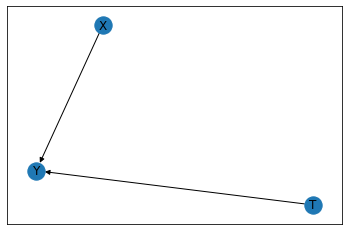

In [43]:
# Illustrate your DGP with a DAG
g1 = nx.DiGraph()
g1.add_edges_from([("X", "Y"), ("T", "Y")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)

$y_i = \tau*T_i+e_i$

Do not control for covariance

In [44]:
class MonteCarlo_1():

    def __init__(self, number):
        self.number = number
    
    def simulate_data(self, beta0, beta1, n, sigma):
        np.random.seed(100)
        T = np.random.binomial(1, 0.5, n)
        x = np.random.normal(50,15,n)
        y = np.random.normal(beta0 + beta1*T + 1*x, 15).astype(int)
    
        return (y,T)
    
    def estimate_OLS_params(self, y, T):
        model = sm.OLS(y,sm.add_constant(T))
        res = model.fit()
        
        return res.params
    
    def run_model(self, beta0, beta1, n, sigma):
        treatment_effect = []
        bias = []
        RMSE = []
        for i in range(self.number):
            y,T = self.simulate_data(beta0, beta1, n,sigma)
            beta0_hat,beta1_hat = self.estimate_OLS_params(y,T)
            y_hat = beta0_hat + beta1_hat * T
            treatment_effect = treatment_effect + [beta1_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y - y_hat) ** 2))]
        return bias, RMSE, treatment_effect

    def table(self, beta0, beta1, n, sigma):
        bias, RMSE, treatment_effect = self.run_model(beta0, beta1, n, sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]


In [45]:
# N=100
N_100 = MonteCarlo_1(10000)
table_100 = N_100.table(1,1,100,1)

# N=1000
N_1000 = MonteCarlo_1(10000)
table_1000 = N_1000.table(1,1,1000,1)

table = pd.concat([pd.Series(table_100),pd.Series(table_1000)],axis = 1)
table.columns = [['N=100','N=1000']]
table.index = [['Bias','RMSE','Treatment Effect']]
table

,N=100,N=1000
Bias,1.857086,-0.373885
RMSE,22.084939,21.250440
Treatment Effect,1.857086,-0.373885


Control for covariance

In [46]:
class MonteCarlo_2():
    
    def __init__(self, number):
        self.number = number

    def simulate_data(self, beta0, beta1, beta2, n, sigma):
        np.random.seed(100)
        T = np.random.binomial(1, 0.5, n)
        x = np.random.normal(50,15,n)
        y = np.random.normal(beta0 + beta1*T + beta2*x, 15).astype(int)
        
        return (y, T, x)
    
    def estimate_OLS_params(self,y,T,x):
        
        mod = sm.OLS(y, sm.add_constant(pd.concat([pd.Series(T),pd.Series(x)], axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_model(self, beta0, beta1, beta2, n, sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for i in range(self.number):
            y,T,x = self.simulate_data(beta0, beta1, beta2, n, sigma)
            beta0_hat,beta1_hat,beta2_hat = self.estimate_OLS_params(y,T,x)
            y_hat = beta0_hat + beta1_hat * T + beta2_hat * x
            treatment_effect = treatment_effect + [beta1_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y - y_hat) ** 2))]
        return bias, RMSE, treatment_effect
    
    def table(self, beta0, beta1, beta2, n, sigma):
        bias, RMSE, treatment_effect = self.run_model(beta0,beta1,beta2,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [47]:

# N=100
N_100 = MonteCarlo_2(10000)
table_100 = N_100.table(1,1,1,100,1)

# N=1000
N_1000 = MonteCarlo_2(10000)
table_1000 = N_1000.table(1,1,1,1000,1)

table = pd.concat([pd.Series(table_100), pd.Series(table_1000)], axis = 1)
table.columns = [['N=100','N=1000']]
table.index = [['Bias','RMSE','Treatment Effect']]
table

/Users/chenxintong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
Bias,1.857086,-0.373885
RMSE,15.241497,14.929098
Treatment Effect,2.147312,0.553387


example of real-life situation that might be consistent with the DGP

Y : Yearly wage in China<br>
X : Degree of education <br>
T : Study abroad or not <br>
In China, the higher degree of education will noramlly lead to higher yearly wage. People who have studied abroad will have a higher wage.

## Q2

In [48]:
np.random.seed(100)
n = 1000
x = np.random.normal(1,10,n)
T = np.random.binomial(1, 1/(1+x**2), n)
y = np.random.normal(1 + 1*x + 1*T, 10).astype(int)

DGP_data2 = pd.DataFrame(dict(T = T, X = x, Y = y))
DGP_data2.to_csv("DGP_data2.csv", index=False)

In [49]:
DGP_data2

,T,X,Y
0,0,-16.497655,-13
1,0,4.426804,10
2,0,12.530358,18
3,0,-1.524360,5
4,0,10.813208,11
...,...,...,...
995,0,-6.379887,-20
996,0,14.263448,3
997,0,10.270035,22
998,0,3.130922,23


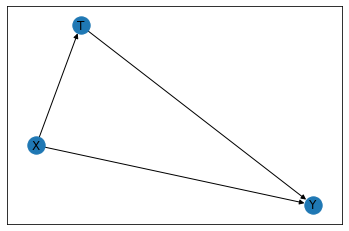

In [50]:
# Illustrate your DGP with a DAG
g1 = nx.DiGraph()
g1.add_edges_from([("X", "T"), ("T", "Y"), ("X", "Y")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)

You fail to control for the confounder 

In [51]:
class MonteCarlo_3():
    
    def __init__(self,number):
        self.number = number

    def simulate_data(self, beta0, beta1, n, sigma):
        np.random.seed(100)
        x = np.random.normal(1,10,n)
        T = np.random.binomial(1, 1/(1+x**2), n)
        y = np.random.normal(beta0 + beta1*T + 1*x, 10).astype(int)

        return (y,T)
    
    def estimate_OLS_params(self,y,T):
        model = sm.OLS(y,sm.add_constant(T))
        res = model.fit()
        
        return res.params
    
    def run_model(self,beta0,beta1,n,sigma):
        treatment_effect = []
        bias = []
        RMSE = []
        for i in range(self.number):
            y,T = self.simulate_data(beta0,beta1,n,sigma)
            beta0_hat,beta1_hat = self.estimate_OLS_params(y,T)
            y_hat = beta0_hat + beta1_hat * T
            treatment_effect = treatment_effect + [beta1_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def table(self,beta0,beta1,n,sigma):
        bias, RMSE, treatment_effect = self.run_model(beta0,beta1,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [52]:
# N=100
N_100 = MonteCarlo_3(10000)
table_100 = N_100.table(1,1,100,1)

# N=1000
N_1000 = MonteCarlo_3(10000)
table_1000 = N_1000.table(1,1,1000,1)

table = pd.concat([pd.Series(table_100),pd.Series(table_1000)],axis = 1)
table.columns = [['N=100','N=1000']]
table.index = [['bias','RMSE','treatment effect']]
table

,N=100,N=1000
bias,2.498339,1.102570
RMSE,14.034247,13.916441
treatment effect,2.498339,1.102570


You do control for the confounder

In [53]:
class MC_Simulator_4():
    
    def __init__(self,number):
        self.number = number

    def simulate_data(self, beta0, beta1, beta2, n, sigma):
        np.random.seed(100)
        x = np.random.normal(1,10,n)
        T = np.random.binomial(1, 1/(1+x**2), n)
        y = np.random.normal(beta0 + beta1*T + beta2*x, 10).astype(int)
        
        return (y,T,x)  
    
    def estimate_OLS_params(self,y,T,x):
        
        mod = sm.OLS(y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(x)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_model(self,beta0,beta1,beta2,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for i in range(self.number):
            y,T,x = self.simulate_data(beta0,beta1,beta2,n,sigma)
            beta0_hat,beta1_hat,beta2_hat = self.estimate_OLS_params(y,T,x)
            y_hat = beta0_hat + beta1_hat * T + beta2_hat * x
            treatment_effect = treatment_effect + [beta1_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def table(self,beta0,beta1,beta2,n,sigma):
        bias, RMSE, treatment_effect = self.run_model(beta0,beta1,beta2,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [54]:
# N=100
N_100 = MC_Simulator_4(10000)
table_100 = N_100.table(1,1,1,100,1)

# N=1000
N_1000 = MC_Simulator_4(10000)
table_1000 = N_1000.table(1,1,1,1000,1)

table = pd.concat([pd.Series(table_100),pd.Series(table_1000)],axis = 1)
table.columns = [['N=100','N=1000']]
table.index = [['Bias','RMSE','Treatment Effect']]
table

/Users/chenxintong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
Bias,2.498339,1.102570
RMSE,9.823177,9.669651
Treatment Effect,-0.184822,1.869764


example of real-life situation that might be consistent with the DGP

T : Total area of a house.<br>
Y : Price of the house.<br>
X : Distance to center of a city.<br>
Generally, if a house is closer to the center of a city, the price will be higher. And the bigger the house is, the higher the price is. However, most houses in the center of the city is smaller than the houses in the countryside.

## Q3

In [55]:
# Simulate a DGP with selection bias into the treatment 
# (variable in between the path from the treatment to the outcome)
np.random.seed(100)
n = 1000
T = np.random.binomial(1, 0.5, n)
y = np.random.normal(1 + 1*T, 10).astype(int)
x = np.random.normal(10 + np.mean(T) * np.mean(y), 10, n)

DGP_data3 = pd.DataFrame(dict(T = T, X = x, Y = y))
DGP_data3.to_csv("DGP_data3.csv", index=False)

In [56]:
DGP_data3

,T,X,Y
0,1,-0.613821,1
1,0,1.604166,-2
2,0,-4.741078,10
3,1,-0.706196,-3
4,0,15.811746,-3
...,...,...,...
995,1,12.067581,11
996,0,8.862671,1
997,0,4.251529,0
998,0,23.863377,-6


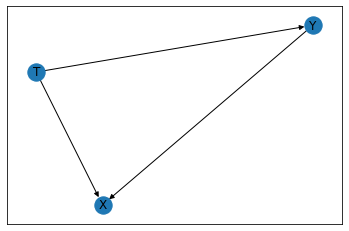

In [64]:
# Illustrate your DGP with a DAG
g1 = nx.DiGraph()
g1.add_edges_from([("T", "X"), ("T", "Y"), ("Y", "X")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)

You control for the variable in between the path from cause to effect

In [58]:
class MonteCarlo_5():

    def __init__(self,number):
        self.number = number

    def simulate_data(self, beta0, beta1, beta2, n, sigma):
        np.random.seed(100)
        T = np.random.binomial(1, 0.5, n)
        y = np.random.normal(1 + 1 * T, 5).astype(int)
        x = np.random.normal(10 + np.mean(T) * np.mean(y), 5, n)
        
        return (y,T,x)
    
    def estimate_OLS_params(self,y,T,x):
        
        mod = sm.OLS(y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(x)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_model(self, beta0, beta1, beta2, n, sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for i in range(self.number):
            y,T,x = self.simulate_data(beta0, beta1, beta2, n, sigma)
            beta0_hat,beta1_hat,beta2_hat = self.estimate_OLS_params(y, T, x)
            y_hat = beta0_hat + beta1_hat * T + beta2_hat * x
            treatment_effect = treatment_effect + [beta1_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y - y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def table(self, beta0, beta1, beta2, n, sigma):
        bias, RMSE, treatment_effect = self.run_model(beta0,beta1,beta2,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [59]:
# N=100
N_100 = MonteCarlo_5(10000)
table_100 = N_100.table(1,1,1,100,1)

# N=1000
N_1000 = MonteCarlo_5(10000)
table_1000 = N_1000.table(1,1,1,1000,1)

table = pd.concat([pd.Series(table_100),pd.Series(table_1000)],axis = 1)
table.columns = [['N=100','N=1000']]
table.index = [['Bias','RMSE','Treatment Effect']]
table

/Users/chenxintong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
Bias,0.783220,0.618050
RMSE,4.978666,4.649170
Treatment Effect,0.785647,0.619232


You do not control for the variable in between the path from cause to effect

In [60]:
class MC_Simulator_6():
    
    def __init__(self,number):
        self.number = number

    def simulate_data(self, beta0, beta1, n, sigma):
        np.random.seed(100)
        T = np.random.binomial(1, 0.5, n)
        y = np.random.normal(1 + 1*T, 5).astype(int)
        x = np.random.normal(10 + np.mean(T) * np.mean(y), 5, n)
        
        return (y,T)    
    
    def estimate_OLS_params(self, y, T):
        mod = sm.OLS(y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_model(self,beta0,beta1,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for i in range(self.number):
            y,T = self.simulate_data(beta0, beta1, n, sigma)
            beta0_hat,beta1_hat = self.estimate_OLS_params(y,T)
            y_hat = beta0_hat + beta1_hat * T
            treatment_effect = treatment_effect + [beta1_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat) ** 2))]
        return bias, RMSE, treatment_effect
    
    def table(self,beta0,beta1,n,sigma):
        bias, RMSE, treatment_effect = self.run_model(beta0,beta1,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [61]:
# N=100
N_100 = MC_Simulator_6(10000)
table_100 = N_100.table(1,1,100,1)

# N=1000
N_1000 = MC_Simulator_6(10000)
table_1000 = N_1000.table(1,1,1000,1)

table = pd.concat([pd.Series(table_100),pd.Series(table_1000)],axis = 1)
table.columns = [['N=100','N=1000']]
table.index = [['Bias','RMSE','Treatment Effect']]
table

,N=100,N=1000
Bias,0.783220,0.61805
RMSE,4.978784,4.64934
Treatment Effect,0.783220,0.61805


example of real-life situation that might be consistent with the DGP

T : Have had jobs or not.<br>
Y : Professional abilities in the area.<br>
X : Position in a company.<br>
If a person have had jobs before, he will have more professional abilities in the area and then will have a higher position in a new company.
